In [23]:
# %% [markdown]
# ## Sustainable Urban Energy Efficiency Prediction
# Hybrid Graph Transformer Network with Comprehensive Visualizations

# %% [code]
# Install dependencies
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [24]:
# %% [code]
# Modified Data Loading Function
def load_preprocess_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
    df = pd.read_excel(url)
    df.columns = ['X'+str(i) for i in range(1,9)] + ['Y1', 'Y2']
    
    num_cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X7']
    cat_cols = ['X6', 'X8']
    
    # Create and fit scalers
    num_scaler = StandardScaler()
    cat_encoder = OneHotEncoder(sparse_output=False)
    
    X_num = num_scaler.fit_transform(df[num_cols])
    X_cat = cat_encoder.fit_transform(df[cat_cols])
    
    y_scaler = StandardScaler()
    y = y_scaler.fit_transform(df[['Y1', 'Y2']])
    
    X_processed = np.hstack([X_num, X_cat])
    
    return df, X_processed, y, y_scaler, num_scaler, cat_encoder

# Load data with scalers
df, X, y, y_scaler, num_scaler, cat_encoder = load_preprocess_data()


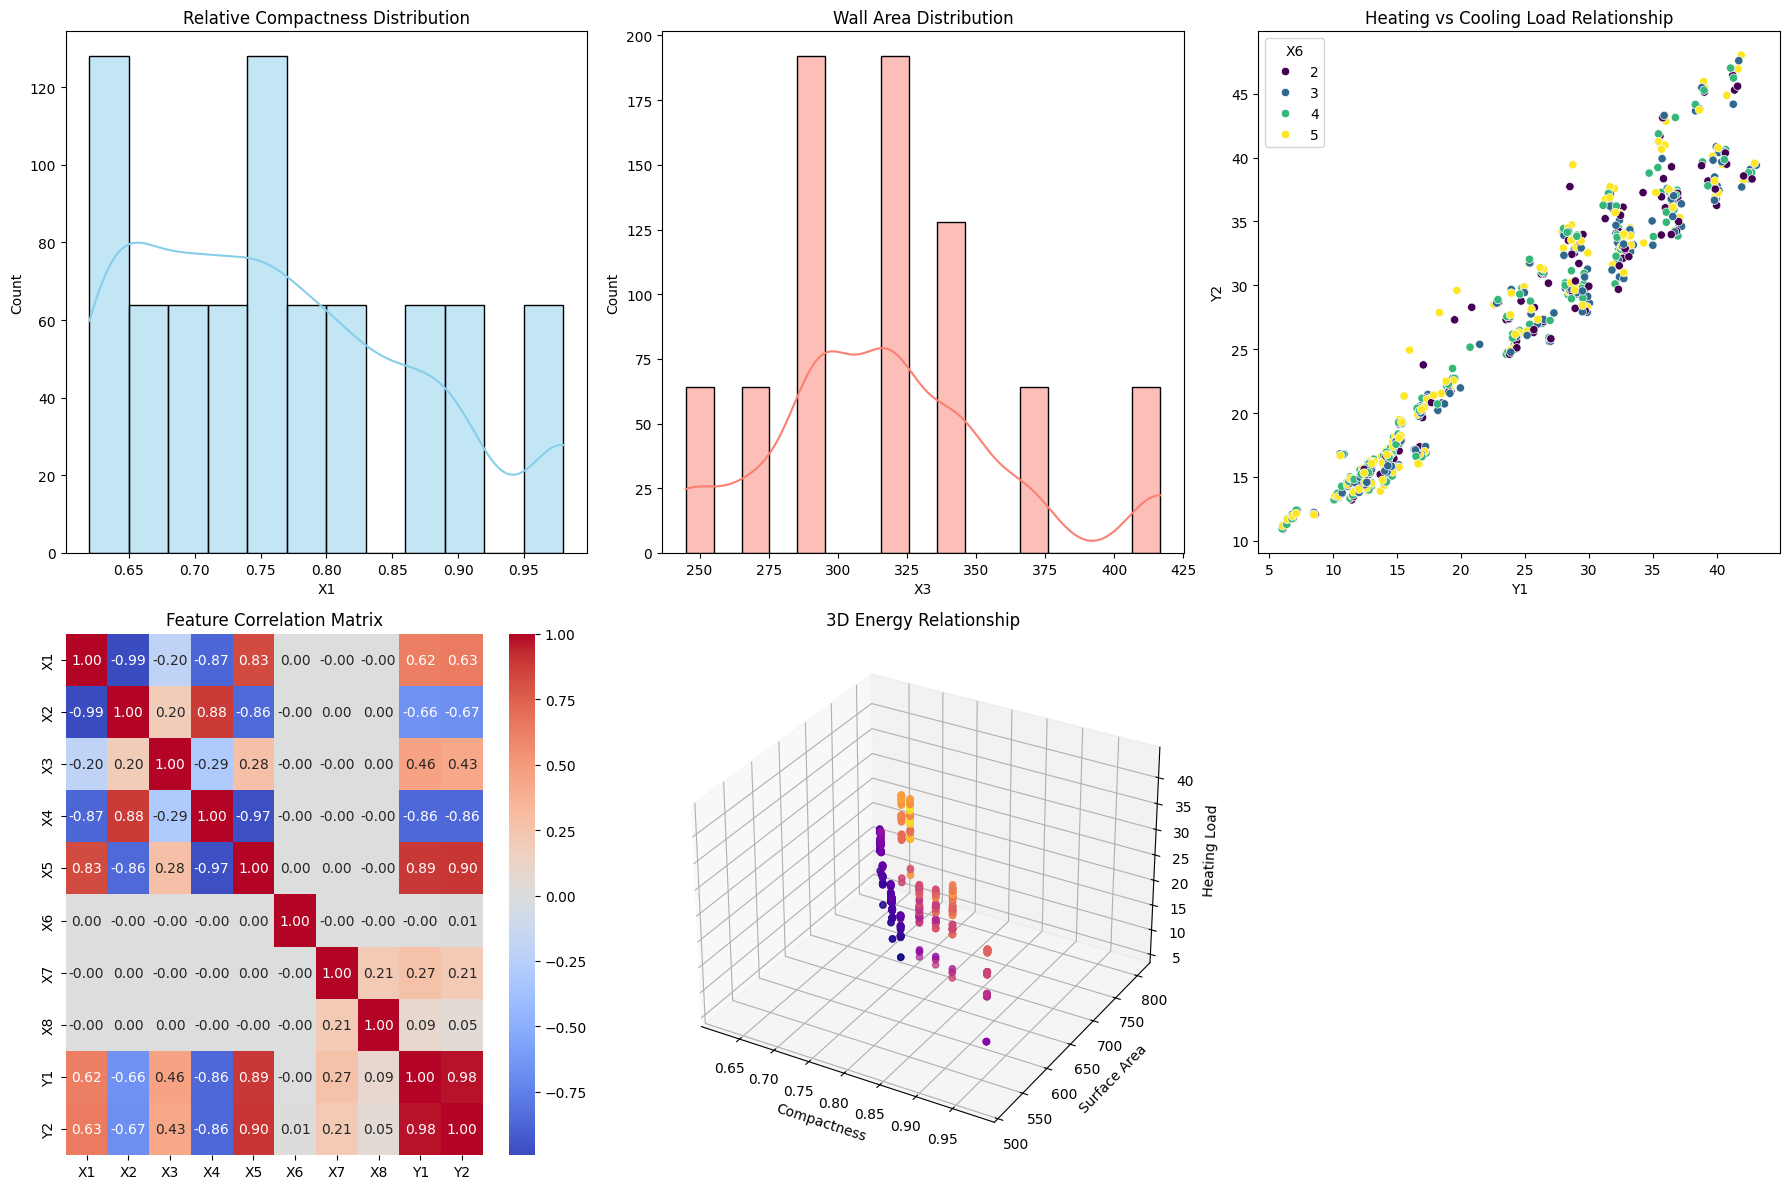

In [25]:
# %% [code]
# Exploratory Data Analysis Visualizations
plt.figure(figsize=(18, 12))

# Distribution of main features
plt.subplot(2, 3, 1)
sns.histplot(df['X1'], color='skyblue', kde=True)
plt.title('Relative Compactness Distribution')

plt.subplot(2, 3, 2)
sns.histplot(df['X3'], color='salmon', kde=True)
plt.title('Wall Area Distribution')

plt.subplot(2, 3, 3)
sns.scatterplot(x='Y1', y='Y2', data=df, hue='X6', palette='viridis')
plt.title('Heating vs Cooling Load Relationship')

# Correlation matrix
plt.subplot(2, 3, 4)
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')

# 3D Visualization
ax = plt.subplot(2, 3, 5, projection='3d')
ax.scatter(df['X1'], df['X2'], df['Y1'], c=df['Y2'], cmap='plasma')
ax.set_xlabel('Compactness')
ax.set_ylabel('Surface Area')
ax.set_zlabel('Heating Load')
plt.title('3D Energy Relationship')

plt.tight_layout()
plt.show()

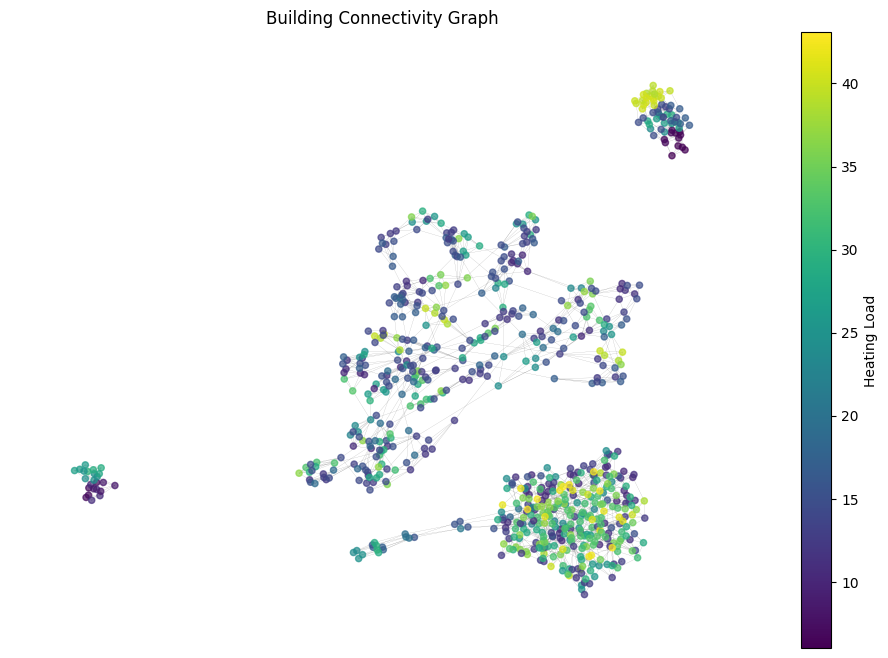

In [26]:
# %% [code]
# Corrected Graph Construction and Visualization
def build_visualize_graph(X, k=5):
    # Build KNN graph
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    _, indices = nbrs.kneighbors(X)
    
    edge_list = []
    for i, neighbors in enumerate(indices):
        edge_list.extend([[i, j] for j in neighbors[1:]])
    
    # Create PyG data object
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    data = Data(x=torch.tensor(X, dtype=torch.float),
                edge_index=edge_index,
                y=torch.tensor(y, dtype=torch.float))
    
    # Visualize graph with proper colorbar
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=20, 
                                  node_color=df['Y1'], 
                                  cmap='viridis',
                                  alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=0.1, alpha=0.5)
    
    # Add colorbar with explicit mappable
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                             norm=plt.Normalize(vmin=df['Y1'].min(), 
                                              vmax=df['Y1'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label('Heating Load')
    
    plt.title('Building Connectivity Graph')
    plt.axis('off')
    plt.show()
    
    return data

data = build_visualize_graph(X)

In [27]:
# %% [code]
# Model Architecture
class SpatialTemporalTransformer(nn.Module):
    def __init__(self, input_dim, gcn_hidden=64, tf_hidden=128, 
                 num_heads=4, output_dim=2):
        super().__init__()
        
        # Spatial Module (GCN)
        self.gcn1 = GCNConv(input_dim, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)
        
        # Temporal Module (Transformer)
        self.tf_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=gcn_hidden, nhead=num_heads,
                                      dim_feedforward=tf_hidden),
            num_layers=2
        )
        
        # Feature Fusion
        self.fc = nn.Sequential(
            nn.Linear(gcn_hidden*2, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Spatial processing
        spatial_feat = self.gcn1(x, edge_index)
        spatial_feat = torch.relu(spatial_feat)
        spatial_feat = self.gcn2(spatial_feat, edge_index)
        
        # Temporal processing
        temporal_feat = self.tf_encoder(spatial_feat.unsqueeze(1))
        temporal_feat = temporal_feat.squeeze(1)
        
        # Feature fusion
        combined = torch.cat([spatial_feat, temporal_feat], dim=1)
        return self.fc(combined)

Epoch 0000 | Train Loss: 1.3620 | Val Loss: 0.9611
Epoch 0100 | Train Loss: 0.0707 | Val Loss: 0.0813
Epoch 0200 | Train Loss: 0.0345 | Val Loss: 0.0279
Epoch 0300 | Train Loss: 0.0266 | Val Loss: 0.0246
Epoch 0400 | Train Loss: 0.0235 | Val Loss: 0.0193
Epoch 0500 | Train Loss: 0.0202 | Val Loss: 0.0177
Epoch 0600 | Train Loss: 0.0244 | Val Loss: 0.0178
Epoch 0700 | Train Loss: 0.0204 | Val Loss: 0.0158
Epoch 0800 | Train Loss: 0.0175 | Val Loss: 0.0161
Epoch 0900 | Train Loss: 0.0168 | Val Loss: 0.0138


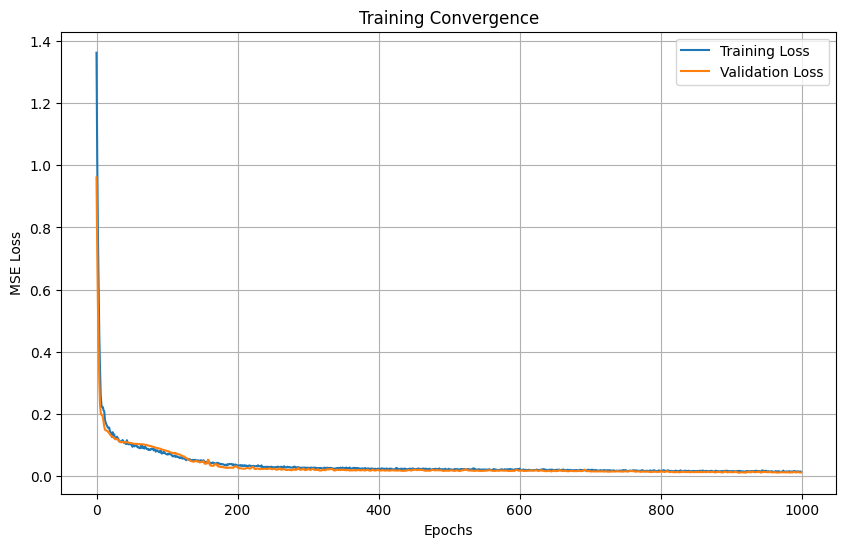

In [28]:
# %% [code]
# Training Setup and Execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpatialTemporalTransformer(input_dim=X.shape[1]).to(device)
data = data.to(device)

# Train-test split
def train_test_split(data, test_size=0.2):
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)
    test_size = int(num_nodes * test_size)
    
    data.train_mask = indices[:-test_size]
    data.test_mask = indices[-test_size:]
    return data

data = train_test_split(data)

# Training configuration
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()
train_loss, val_loss = [], []

# Training loop
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        pred = model(data)
        v_loss = criterion(pred[data.test_mask], data.y[data.test_mask])
    
    train_loss.append(loss.item())
    val_loss.append(v_loss.item())
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch:04d} | Train Loss: {loss:.4f} | Val Loss: {v_loss:.4f}')

# Loss curve visualization
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

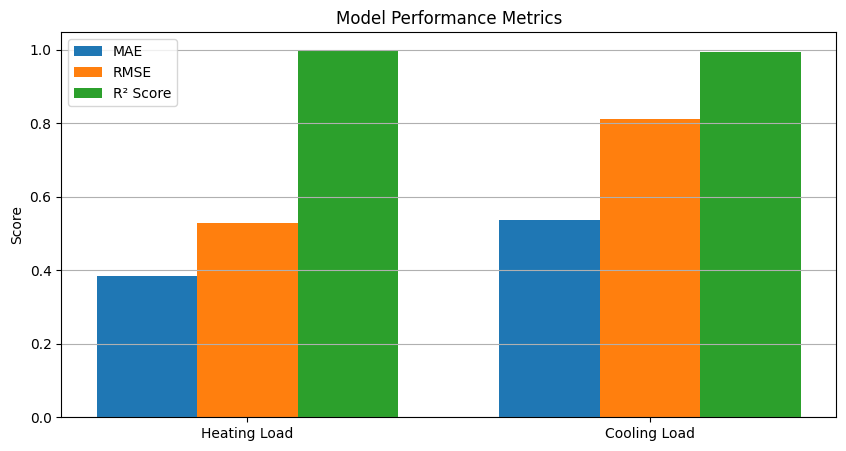

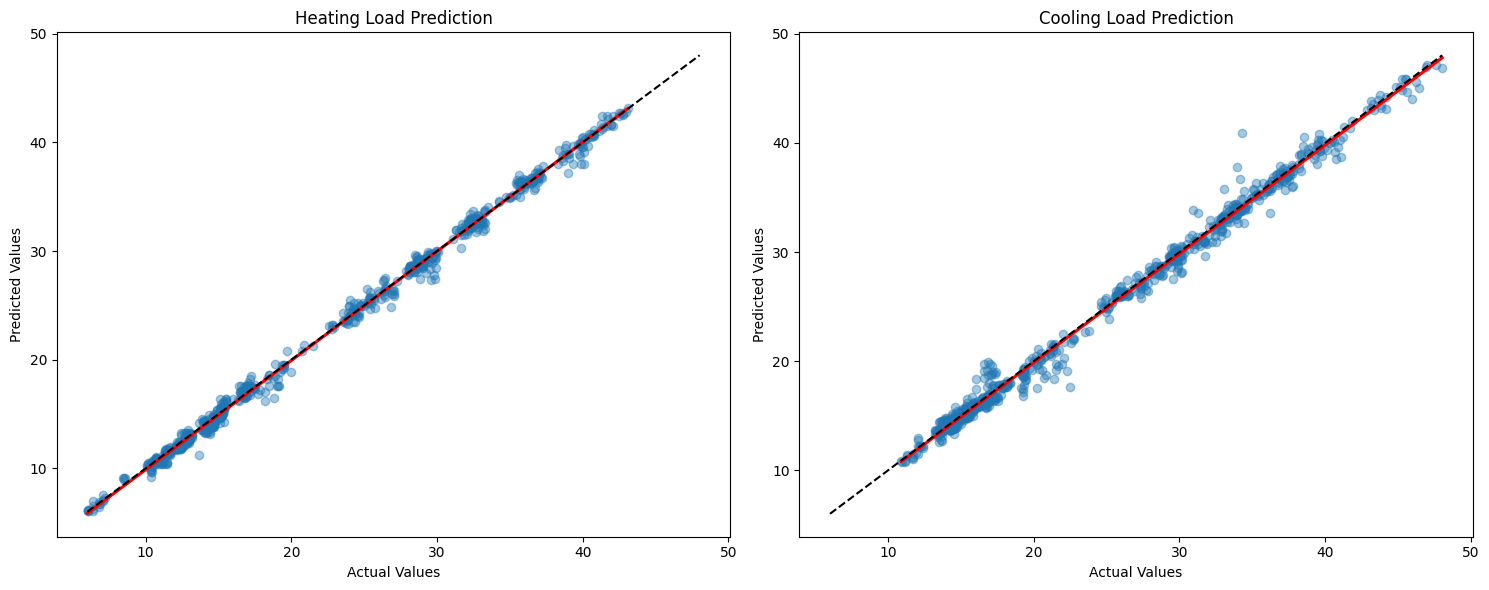

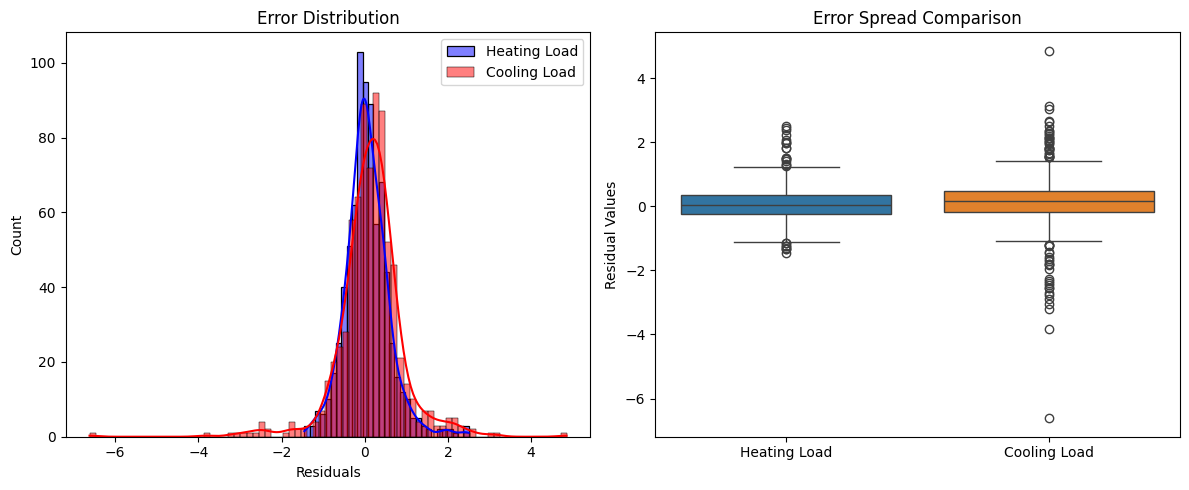

In [29]:
# %% [code]
# Results Visualization and Analysis
model.eval()
with torch.no_grad():
    pred = model(data).cpu().numpy()
    true = data.y.cpu().numpy()

# Inverse scaling
pred = y_scaler.inverse_transform(pred)
true = y_scaler.inverse_transform(true)

# Calculate metrics
mae = np.mean(np.abs(pred - true), axis=0)
rmse = np.sqrt(np.mean((pred - true)**2, axis=0))
r2 = r2_score(true, pred, multioutput='raw_values')

# Metrics visualization
plt.figure(figsize=(10, 5))
metrics = ['Heating Load', 'Cooling Load']
x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width, mae, width, label='MAE')
plt.bar(x, rmse, width, label='RMSE')
plt.bar(x + width, r2, width, label='R² Score')

plt.title('Model Performance Metrics')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.legend()
plt.grid(axis='y')
plt.show()

# Prediction vs Actual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for i, target in enumerate(['Heating Load', 'Cooling Load']):
    sns.regplot(x=true[:,i], y=pred[:,i], ax=axes[i], 
                scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
    axes[i].set_title(f'{target} Prediction')
    axes[i].set_xlabel('Actual Values')
    axes[i].set_ylabel('Predicted Values')
    axes[i].plot([true.min(), true.max()], [true.min(), true.max()], 'k--')
plt.tight_layout()
plt.show()

# Error distribution analysis
residuals = true - pred
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals[:,0], kde=True, color='blue', label='Heating Load')
sns.histplot(residuals[:,1], kde=True, color='red', label='Cooling Load')
plt.title('Error Distribution')
plt.xlabel('Residuals')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=pd.DataFrame(residuals, columns=metrics))
plt.title('Error Spread Comparison')
plt.ylabel('Residual Values')
plt.tight_layout()
plt.show()

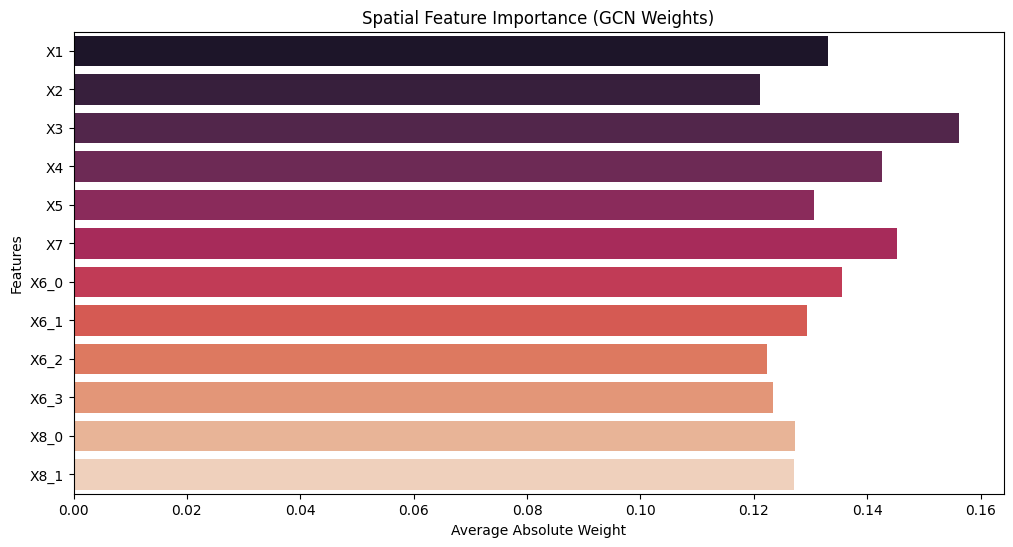

In [30]:
# %% [code]
# Corrected Feature Importance Visualization
def visualize_feature_importance(model, original_features):
    # Get processed feature names including encoded categoricals
    num_features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X7']
    cat_features = [f'X6_{i}' for i in range(4)] + [f'X8_{i}' for i in range(2)]
    all_features = num_features + cat_features
    
    # Get weights from first GCN layer
    gcn_weights = model.gcn1.lin.weight.detach().cpu().numpy()
    importance = np.mean(np.abs(gcn_weights), axis=0)
    
    # Ensure equal lengths
    if len(importance) != len(all_features):
        print(f"Warning: Truncating features ({len(all_features)}) to match importance scores ({len(importance)})")
        all_features = all_features[:len(importance)]
        importance = importance[:len(all_features)]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importance, y=all_features, palette='rocket')
    plt.title('Spatial Feature Importance (GCN Weights)')
    plt.xlabel('Average Absolute Weight')
    plt.ylabel('Features')
    plt.show()

# Use corrected feature names
visualize_feature_importance(model, df.columns)

In [32]:
# %% [code]
# Energy Efficiency Optimization Simulation
def optimize_efficiency(model, num_scaler, cat_encoder, base_values):
    # Split base values into numerical and categorical
    num_values = base_values[[0, 1, 2, 3, 4, 6]]  # Numerical features (X1-X5, X7)
    cat_values = base_values[[5, 7]]               # Categorical features (X6, X8)
    
    # Convert categorical values to integers
    cat_values = np.round(cat_values).astype(int)
    
    # Scale and encode features
    scaled_num = num_scaler.transform([num_values])
    encoded_cat = cat_encoder.transform([cat_values])
    
    # Create parameter grid
    compactness = np.linspace(0.7, 1.0, 50)
    glazing_ratio = np.linspace(0.0, 0.4, 50)
    
    results = []
    for comp in compactness:
        for glz in glazing_ratio:
            modified_num = scaled_num.copy()
            modified_num[0, 0] = comp  # X1 position
            modified_num[0, 5] = glz    # X7 position
            
            features = np.hstack([modified_num, encoded_cat])
            
            with torch.no_grad():
                pred = model(torch.tensor(features, dtype=torch.float).cpu().numpy())
                pred = y_scaler.inverse_transform(pred)
            results.append([comp, glz, pred[0,0], pred[0,1]])

    
    results = np.array(results)
    
    # 3D Optimization Surface
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    for ax, z in zip([ax1, ax2], [2, 3]):
        surf = ax.plot_trisurf(results[:,0], results[:,1], results[:,z],
                             cmap='viridis', linewidth=0, antialiased=False)
        ax.set_xlabel('Compactness')
        ax.set_ylabel('Glazing Ratio')
        ax.set_zlabel('Energy Load')
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    ax1.set_title('Heating Load Optimization Landscape')
    ax2.set_title('Cooling Load Optimization Landscape')
    plt.show()

# Get valid base sample using mode for categorical features
def get_base_sample(df):
    num_cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X7']
    cat_cols = ['X6', 'X8']
    
    num_base = df[num_cols].median().values
    cat_base = df[cat_cols].mode().values[0]
    
    return np.concatenate([num_base, cat_base])

base_sample = get_base_sample(df)
optimize_efficiency(model, num_scaler, cat_encoder, base_sample)

ValueError: Found unknown categories [0] in column 0 during transform